In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Tạo dữ liệu
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
temperature_data = 20 + 10 * np.sin(np.linspace(0, 3 * np.pi, len(date_range))) + np.random.normal(0, 2, len(date_range))

# Tạo DataFrame
data = pd.DataFrame({'date': date_range, 'temperature': temperature_data})
data.set_index('date', inplace=True)

# Tạo biểu đồ
fig = go.Figure()

# Thêm dữ liệu vào biểu đồ
fig.add_trace(go.Scatter(x=data.index, y=data['temperature'], mode='lines', name='Nhiệt độ', line=dict(color='blue', width=2)))

# Cài đặt tiêu đề và nhãn
fig.update_layout(
    title='Biểu đồ Time Series Nhiệt độ',
    xaxis_title='Ngày',
    yaxis_title='Nhiệt độ (°C)',
    xaxis_rangeslider_visible=True
)

# Thêm các giá trị cao nhất và thấp nhất
max_temp = data['temperature'].max()
min_temp = data['temperature'].min()
fig.add_annotation(x=data['temperature'].idxmax(), y=max_temp, text='Nhiệt độ cao nhất', showarrow=True, arrowhead=2)
fig.add_annotation(x=data['temperature'].idxmin(), y=min_temp, text='Nhiệt độ thấp nhất', showarrow=True, arrowhead=2)

# Hiển thị biểu đồ
fig.show()


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Tạo dữ liệu cho LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Chia dữ liệu
time_step = 30
X, y = create_dataset(data_scaled, time_step)

# Reshape dữ liệu cho LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Đầu ra là 1 giá trị

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X, y, epochs=50, batch_size=32)


Epoch 1/50


d:\Install App\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2345
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0323
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0188
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0126
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0115
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0113
Epoch 16/50
11/

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


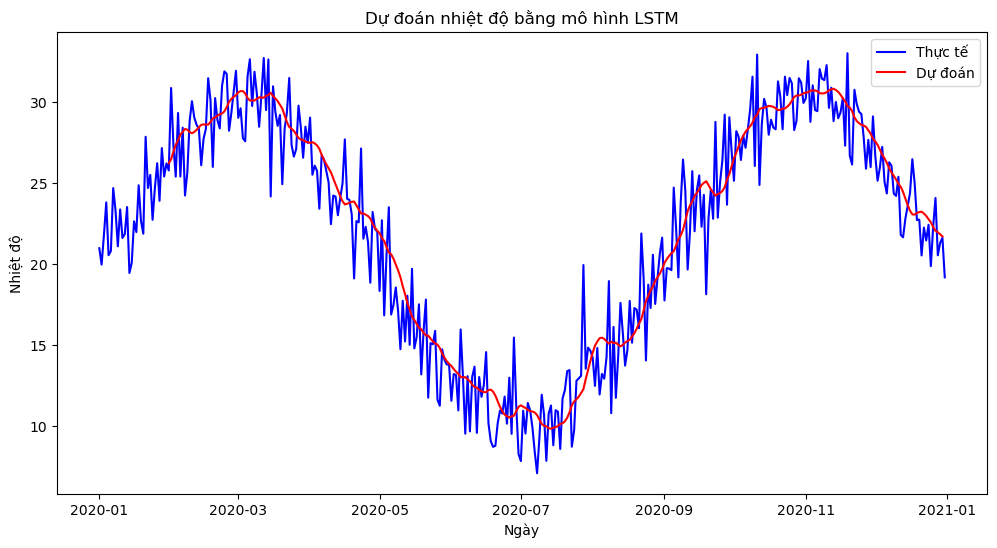

In [20]:
# Dự đoán
train_predict = model.predict(X)

# Chuyển đổi dự đoán về giá trị thực
train_predict = scaler.inverse_transform(train_predict)

# Hiển thị kết quả
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature'], label='Thực tế', color='blue')
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict, label='Dự đoán', color='red')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.title('Dự đoán nhiệt độ bằng mô hình LSTM')
plt.show()
